<a href="https://colab.research.google.com/github/superbunny38/2021DeepLearning/blob/main/pytorch/Chap_8_(1)_Transfer_Learning_using_ResNet34.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch.nn as nn
import torch.nn.functional as F

# ResNet

In [2]:
class ResNetBlock(nn.Module):
    
    def __init__(self,in_channels,output_channels,stride):
        
        super().__init__()
        self.convolutional_1 = nn.Conv2d(in_channels,output_channels,kernel_size=3,stride=stride,padding=1,bias=False)
        self.bn1 = nn.BatchNorm2d(output_channels)
        self.convolutional_2 = nn.Conv2d(output_channels,output_channels,kernel_size=3,stride=stride,padding=1,bias=False)
        self.bn2 = nn.BatchNorm2d(output_channels)
        self.stride = stride
        
    def forward(self,x):
        
        residual = x#입력
        out = self.convolutional_1(x)
        out = F.relu(self.bn1(out),inplace=True)
        out = self.convolutional_2(out)
        out = self.bn2(out)
        out += residual#출력에 입력이 더해짐
        return F.relu(out)

In [4]:
from torchvision.models import resnet18
resnet_model = resnet18(pretrained = False)
resnet_model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

# 개와 고양이 데이터셋에 대한 ResNet 모델 훈련

## 필요한 모듈 import

In [5]:
import pandas as pd
from glob import glob
import os
from shutil import copyfile
from torch.utils.data import Dataset
from PIL import Image
import numpy as np
from numpy.random import permutation
import matplotlib.pyplot as plt

from torchvision import transforms
from torchvision.datasets import ImageFolder
from torchvision.models import resnet18,resnet34
from torchvision.models.inception import inception_v3
from torch.utils.data import DataLoader
from torch.autograd import Variable
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import warnings
warnings.filterwarnings("ignore")

import pickle
%matplotlib inline
print("PyTorch Version: ",torch.__version__)
import torchvision
print("Torchvision Version: ",torchvision.__version__)

PyTorch Version:  1.10.0+cu111
Torchvision Version:  0.11.1+cu111


In [6]:
is_cuda = torch.cuda.is_available()
is_cuda

True

In [7]:
!nvidia-smi

Tue Jan  4 01:25:24 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P8    26W / 149W |      3MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [8]:
torch.cuda.memory_allocated()

0

In [9]:
torch.cuda.empty_cache()

## 파이토치 데이터셋 형성하기

In [10]:
!git clone https://github.com/ardamavi/Dog-Cat-Classifier repo
!mkdir workspace
%mv /content/repo/Data/Train_Data /content/workspace
%cd workspace

Cloning into 'repo'...
remote: Enumerating objects: 1654, done.
remote: Total 1654 (delta 0), reused 0 (delta 0), pack-reused 1654
Receiving objects: 100% (1654/1654), 34.83 MiB | 29.72 MiB/s, done.
Resolving deltas: 100% (147/147), done.
/content/workspace


In [11]:
import glob
path = "/content/workspace/Train_Data"
#read all the files inside the folder
dog_files = [f for f in glob.glob("/content/workspace/Train_Data/dog/*.jpg")]
cat_files = [f for f in glob.glob("/content/workspace/Train_Data/cat/*.jpg")]

files = dog_files+cat_files
print(f"Total number of images: {len(files)}")
no_of_images = len(files)
shuffle = np.random.permutation(no_of_images)
os.mkdir(os.path.join(path, "train"))
os.mkdir(os.path.join(path, "valid"))
for t in ['train','valid']:
  for folder in ['dog/', 'cat/']:
    os.mkdir(os.path.join(path,t,folder))

Total number of images: 1399


In [12]:
#검증데이터 넣기
for i in shuffle[:250]:#250개
  folder = files[i].split("/")[-2].split(".")[0]
  image = files[i].split('/')[-1]
  image = image[4:]
  os.rename(files[i], os.path.join(path, 'valid', folder, image))

In [13]:
#학습데이터 넣기
for i in shuffle[250:]:
  folder = files[i].split("/")[-2].split(".")[0]
  image = files[i].split('/')[-1]
  image = image[4:]
  os.rename(files[i], os.path.join(path, 'train', folder, image))

In [14]:
transform_data = transforms.Compose([
        transforms.Resize((299,299)),
        transforms.ToTensor(),
        transforms.Normalize([0.30, 0.40, 0.40], [0.20, 0.20, 0.20])
    ])

In [15]:
from torchvision.datasets import ImageFolder
train_dataset = ImageFolder("/content/workspace/Train_Data/train", transform_data)
validation_dataset = ImageFolder("/content/workspace/Train_Data/valid", transform_data)
classes=2

In [17]:
train_dataset.class_to_idx#클래스 관련 인덱스 간의 매핑 제공

{'cat': 0, 'dog': 1}

In [18]:
train_dataset.classes#클래스들의 리스트를 제공

['cat', 'dog']

In [19]:
import matplotlib.pyplot as plt
def imshow(inp):
  #imshow for tensor
  inp = inp.numpy().transpose((1,2,0))
  mean = np.array([0.12, 0.12, 0.40])
  std = np.array([0.22, 0.20,0.20])
  inp = std*inp+mean
  inp = np.clip(inp,0,1)
  plt.imshow(inp)

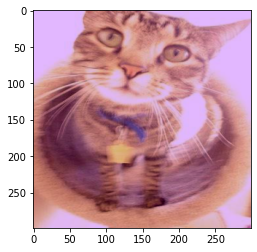

In [21]:
imshow(train_dataset[30][0])

## 훈련과 검증을 위한 데이터로더 생성

In [22]:
training_data_loader = DataLoader(train_dataset,batch_size=32,shuffle=False,num_workers=4)
validation_data_loader = DataLoader(validation_dataset,batch_size=32,shuffle=False,num_workers=4)

In [24]:
training_data_loader.dataset

Dataset ImageFolder
    Number of datapoints: 1149
    Root location: /content/workspace/Train_Data/train
    StandardTransform
Transform: Compose(
               Resize(size=(299, 299), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
               Normalize(mean=[0.3, 0.4, 0.4], std=[0.2, 0.2, 0.2])
           )

In [25]:
validation_data_loader.dataset

Dataset ImageFolder
    Number of datapoints: 250
    Root location: /content/workspace/Train_Data/valid
    StandardTransform
Transform: Compose(
               Resize(size=(299, 299), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
               Normalize(mean=[0.3, 0.4, 0.4], std=[0.2, 0.2, 0.2])
           )

## ResNet 모델 생성하기

In [26]:
resnet_model = resnet34(pretrained=True)

if is_cuda:
    resnet_model = resnet_model.cuda()

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

In [27]:
resnet_model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [39]:
list(resnet_model.children())[-1]#마지막 레이어 시각화

Linear(in_features=512, out_features=1000, bias=True)

In [42]:
li = [1,2,3]
li[:-1]

[1, 2]

In [40]:
m = nn.Sequential(*list(resnet_model.children())[:-1])#마지막 선형 레이어 삭제 됨

In [41]:
m

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

In [43]:
for p in resnet_model.parameters():
  p.requires_grad = False#freeze layer

## 합성곱의 특징 추출하기

In [44]:
# Stores the labels of the train data
training_data_labels = [] 

# Stores the pre convoluted features of the train data
training_features = [] 

In [45]:
#Iterate through the train data and store the calculated features and the labels
#m: model
for data,label in training_data_loader:
    with torch.no_grad(): # To help with memory issues
        output = m(Variable(data.cuda()))#output
        output = output.view(output.size(0),-1)
        training_data_labels.extend(label)
        training_features.extend(output.cpu().data)

In [48]:
training_data_labels[:10]

[tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(0)]

In [51]:
training_features[:1]

[tensor([1.1705, 1.3006, 1.0084, 0.3976, 1.6268, 0.2498, 0.4994, 0.2976, 1.9596,
         1.1434, 2.2097, 1.2946, 0.1146, 1.1453, 0.4199, 2.5255, 1.1618, 0.4012,
         2.6064, 0.5092, 3.2836, 0.3431, 0.9885, 0.1488, 2.0178, 1.3996, 0.7998,
         0.1636, 0.2522, 1.2592, 0.4780, 0.4498, 1.1040, 1.1095, 0.7502, 0.7975,
         0.5791, 0.7963, 0.6361, 1.6294, 0.9612, 0.2790, 0.3648, 0.8929, 0.6586,
         1.3240, 0.3823, 1.9865, 0.7296, 0.4264, 0.8095, 1.7441, 0.7747, 0.8232,
         1.8006, 0.2541, 0.3738, 3.1367, 2.0621, 0.2400, 0.5832, 0.9633, 0.6599,
         0.4824, 0.1765, 0.8744, 1.6294, 0.1816, 1.1077, 1.4764, 1.0296, 0.4445,
         0.5758, 1.9992, 0.3228, 0.5266, 0.5628, 1.9904, 0.6676, 1.6216, 1.1925,
         0.3513, 1.8375, 0.4547, 0.2503, 1.3332, 2.7719, 0.1955, 0.8840, 1.7185,
         2.3609, 0.1985, 0.1662, 0.9185, 0.1724, 0.2327, 0.5358, 1.1555, 1.6302,
         0.5198, 0.9109, 0.7467, 0.5123, 0.7294, 0.3638, 1.6162, 0.2761, 3.3757,
         1.3681, 0.6580, 1.1

In [52]:
len(training_data_labels)

1149

In [53]:
#For validation data

#Iterate through the validation data and store the calculated features and the labels

validation_data_labels = []
validation_features = []
for d,la in validation_data_loader:
    with torch.no_grad(): # To help with memory issues
        o = m(Variable(d.cuda()))
        o = o.view(o.size(0),-1)
        validation_data_labels.extend(la)
        validation_features.extend(o.cpu().data)

In [54]:
len(validation_data_labels)

250

### 특징들로부터 데이터 선택하는 클래스 생성

In [55]:
class FeaturesDataset(Dataset):
    
    def __init__(self,features_list,labels_list):
        self.features_list = features_list#사전 합성곱이 계산된 특징
        self.labels_list = labels_list
        
    def __getitem__(self,index):
        return (self.features_list[index],self.labels_list[index])
    
    def __len__(self):
        return len(self.labels_list)

### create feature dataset 

In [56]:
#Creating dataset for train and validation
train_features_dataset = FeaturesDataset(training_features,training_data_labels)
validation_features_dataset = FeaturesDataset(validation_features,validation_data_labels)

#Creating data loader for train and validation
train_features_loader = DataLoader(train_features_dataset,batch_size=64,shuffle=True)
validation_features_loader = DataLoader(validation_features_dataset,batch_size=64)

## Create Linear Model for mapping calculated features to related category

In [66]:
class FullyConnectedLinearModel(nn.Module):
    
    def __init__(self,input_size,output_size):
        super().__init__()
        self.fc = nn.Linear(input_size,output_size)

    def forward(self,inp):
        out = self.fc(inp)
        return out

In [67]:
fully_connected_in_size = 512

In [68]:
fc = FullyConnectedLinearModel(fully_connected_in_size,classes)
if is_cuda:
    fc = fc.cuda()

In [69]:
optimizer = optim.Adam(fc.parameters(),lr=0.0001)

## Train and Validate model

In [74]:
def fit(epoch, model,data_loader,phase='training',volatile=False):
    if phase == 'training':
        model.train()
    if phase == 'validation':
        model.eval()
        volatile=True
    cummulative_loss = 0.0
    cummulative_correct = 0
    for batch_idx , (data,target) in enumerate(data_loader):
        if is_cuda:
            data,target = data.cuda(),target.cuda()
        data , target = Variable(data,volatile),Variable(target)
        #print("data size:",data.size())
        if phase == 'training':
            optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output,target)
        
        cummulative_loss += F.cross_entropy(output,target,size_average=False).data
        preds = output.data.max(dim=1,keepdim=True)[1]
        cummulative_correct += preds.eq(target.data.view_as(preds)).cpu().sum()
        if phase == 'training':
            loss.backward()
            optimizer.step()
    
    loss = cummulative_loss/len(data_loader.dataset)
    accuracy = 100. * cummulative_correct/len(data_loader.dataset)
    
    print(f'{phase} loss is {loss} and {phase} accuracy is {cummulative_correct}/{len(data_loader.dataset)}{accuracy}')
    return loss,accuracy

In [75]:
train_losses , train_accuracy = [],[]
validation_losses , validation_accuracy = [],[]
for epoch in range(1,20):
    epoch_loss, epoch_accuracy = fit(epoch,fc,train_features_loader,phase='training')
    validation_epoch_loss , validation_epoch_accuracy = fit(epoch,fc,validation_features_loader,phase='validation')
    train_losses.append(epoch_loss)
    train_accuracy.append(epoch_accuracy)
    validation_losses.append(validation_epoch_loss)
    validation_accuracy.append(validation_epoch_accuracy)

training loss is 0.7257371544837952 and training accuracy is 571/114949.69538879394531
validation loss is 0.7164276838302612 and validation accuracy is 126/25050.400001525878906
training loss is 0.7211541533470154 and training accuracy is 569/114949.521324157714844
validation loss is 0.716623067855835 and validation accuracy is 125/25050.0
training loss is 0.7177855372428894 and training accuracy is 582/114950.652740478515625
validation loss is 0.7124837040901184 and validation accuracy is 128/25051.20000076293945
training loss is 0.7176752686500549 and training accuracy is 578/114950.30461120605469
validation loss is 0.7130293250083923 and validation accuracy is 129/25051.599998474121094
training loss is 0.714719831943512 and training accuracy is 595/114951.78416061401367
validation loss is 0.7090024352073669 and validation accuracy is 129/25051.599998474121094
training loss is 0.7134042978286743 and training accuracy is 601/114952.30635452270508
validation loss is 0.7090708613395691 